## Classification

### Basic Setup

In [3]:
import sys

assert sys.version_info >= (3,7) # require python version>= 3.7

In [4]:
from packaging import version

import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1") # need sklearn version >= 1.0.1

In [7]:
import matplotlib.pyplot as plt

# define the define font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [23]:
# also define a funtion which will use to save images

from pathlib import Path

IMAGE_PATH = Path() / "images" / "classification"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_image(fig_id, tigh_layout=True, extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{extension}"
    if tigh_layout:
        plt.tight_layout()
    plt.savefig(path, format=extension, dpi=resolution)

### MNIST

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # we set as_Frame=False because opneml generally return input as DateFrame but MNIST datasets contain IMages so DateFrame is notnot ideal for images

In [13]:
X, y = mnist.data, mnist.target

In [16]:
X, X.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784)),
 (70000, 784))

In [17]:
y, y.shape

(array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object),
 (70000,))

In [18]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [19]:
# Each image size of 28*28 pixel and that's why each image has 784 features

In [20]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

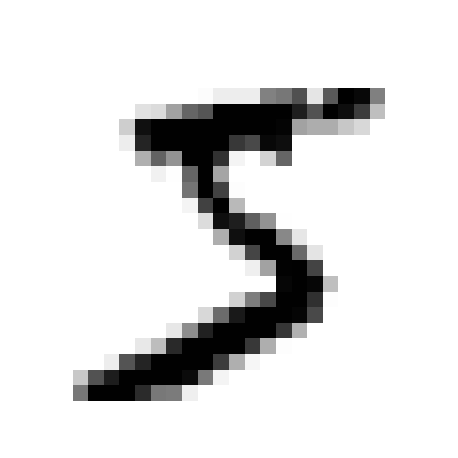

In [24]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary") #cmap="binary" means to get a grayscale color map where 0 is white and 255 is black
    plt.axis("off")
    
some_digit = X[0]
plot_digit(some_digit)
save_image("some_digit")
    

In [25]:
# above image seems like a 5
y[0]

'5'

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[:60000]

### Training a Binary Classifier

In [28]:
# will try to identify and ignore other than '5'
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [29]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
sgd_classifier.predict([some_digit])

array([ True])

### Performance measures of SGD

In [32]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=5, scoring="accuracy") # cv=3 represent k-fold means splitting the dateset at 3 folds here

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [35]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train_5)
print(dummy_classifier.predict(X_train))

[False False False ... False False False]


In [36]:
cross_val_score(dummy_classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.90958333, 0.90966667, 0.90966667, 0.90966667, 0.90966667])

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_prediction = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_prediction)

cm #Each row in a confusion matrix represents an actual class, while each column represents a predicted class

array([[53892,   687],
       [ 1891,  3530]])

In [40]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [41]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_prediction)

0.8370879772350012

In [42]:
recall_score(y_train_5, y_train_prediction)

0.6511713705958311

In [43]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_prediction)

0.7325171197343847

### Precision/ Recall trade-off

In [44]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [46]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [48]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

In [50]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

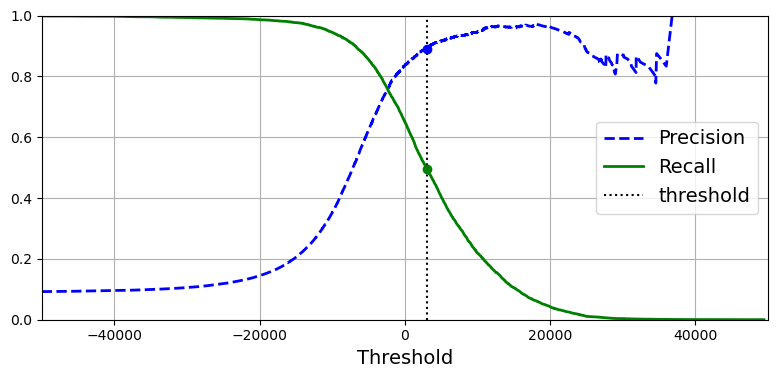

In [62]:
threshold = 3000
plt.figure(figsize=(8, 4)) 
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_image("precision_recall_vs_threshold_plot")

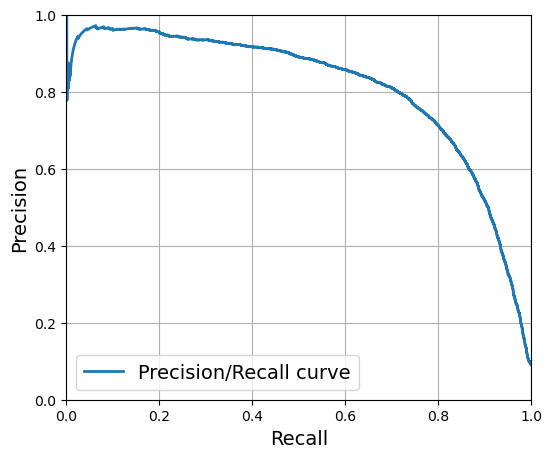

In [64]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

In [65]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991441817)

In [66]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [67]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [68]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### ROC Curve

In [69]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

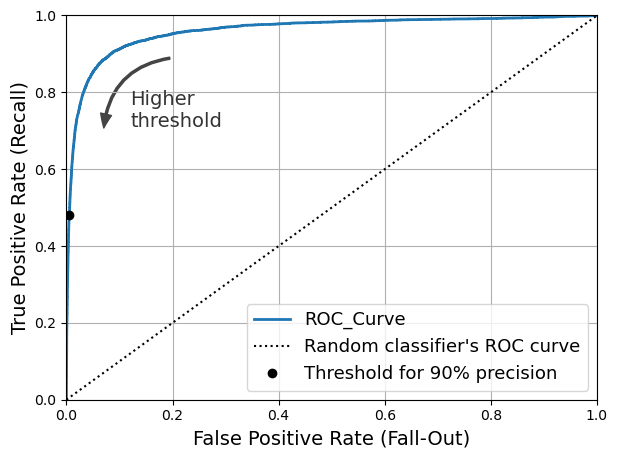

In [81]:
# Plot FPR against TPR
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC_Curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_image("roc_curve_plot")

In [82]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [84]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [85]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [86]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [87]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

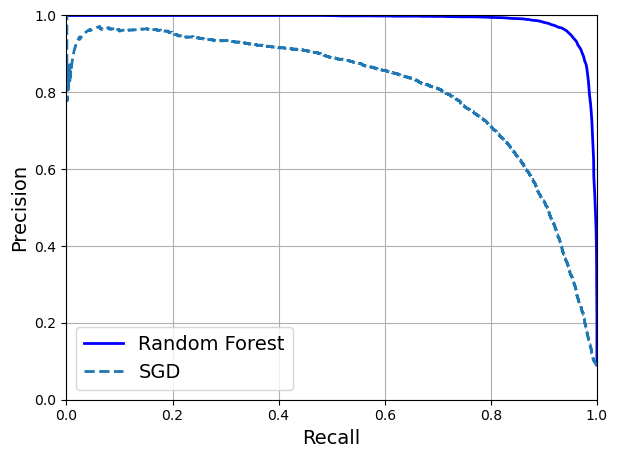

In [88]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_image("pr_curve_comparison_plot")

In [89]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9270445185330457

In [90]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

In [91]:
precision_score(y_train_5, y_train_pred_forest)

0.9895331798199707

In [92]:
recall_score(y_train_5, y_train_pred_forest)

0.8719793396052389

### Multiclass Classification